In [1]:
import datetime
import warnings
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List

from dateutil.relativedelta import relativedelta

from tqdm.notebook import tqdm

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('data_for_train/consumption_and_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


Для предсказания потребления воспользуемся регрессионными моделями. Для этого потребуется определенным образом собрать из данных вектора, в которые планиуется закодировать данные потреблении и температуре за n часов до, данные о потреблении и температуре за этот же день в прошлом году. Перекодируем временной индекс в сигналы синуса и косинуса с суточной, недельной, месячной и годовой частотой, а также воспользуемся данными о том, рабочий это день или выходной.

In [3]:
calendar = pd.read_excel('data_for_train/calendar.xlsx', index_col='day')
print('calendar.shape', calendar.shape)
calendar.head(7)

calendar.shape (2922, 1)


,day_off
day,
2016-01-01,1
2016-01-02,1
2016-01-03,1
2016-01-04,0
2016-01-05,0
2016-01-06,0
2016-01-07,1


Напишем функцию, которая будет последовательно реализовывать данные шаги и формировать датасет.

In [60]:
def make_data(df               : pd.DataFrame,
              calendar         : pd.DataFrame,
              lags             : List[int],
              y_lags           : List[int],
              time_freq        : List[str],
              ) -> pd.DataFrame:
    """
    Функция, формирующая датасет для обучения регрессионных моделей.
    На вход требует:

    Датафрейм df, содержащий данные о почасовом потреблении и темпераутре.

    Датафрейм calendar, содержащий данные о том, выходной день или нет.

    Список лагов, по которым будет осуществляться сдвиг во времени назад.
    Рекомендуется давать начиная с нуля. Последнее значение не включается.

    Список лагов для целевой переменной, по которым будет осуществляться сдвиг во времени вперед.
    Рекомендуется давать начиная с единицы. Последнее значение не включается.

    Список частот, по которым необходимо кодировать время и дату.
    Доступны: {'hour', 'day_of_year', 'month', 'weekday'}

    Логическое значение True/False на включение прошлогодних данных
    (требовательно по времени...)
    """
    time_dict = {'hour'        : 24,
                 'day_of_year' : 365.25,
                 'month'       : 12,
                 'weekday'     : 7}

    # так как планируется применять данную функцию и для подготовки данных для предсказания
    # без известного заранее результата, раширим датафрейм вперед, для того, чтобы знать дату и время
    new_index = pd.date_range(start=df.index[-1], periods=y_lags[-1] + 1, freq='H')[y_lags[0] + 1:]
    df = pd.concat([df, pd.DataFrame(index=new_index)])

    # присоединим информацию о выходных и рабочих днях
    df['date'] = pd.to_datetime(df.index.date, format='%Y-%m-%d')
    df = pd.merge(df, calendar, left_on='date', right_index=True, how='left')
    df.drop('date', axis=1, inplace=True)

    # извлечем тригонометрическую фичу из времени
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for time_component in time_freq:
            df[time_component] = getattr(df.index, time_component)
            df[f'{time_component}_sin'] = np.sin( 2 * np.pi * df[time_component] / time_dict[time_component])
            df[f'{time_component}_cos'] = np.cos( 2 * np.pi * df[time_component] / time_dict[time_component])
            df.drop([time_component], axis=1, inplace=True)

    # присоединим сдвиги во времени для мощности и температуры
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in lags:
            df[f'P_lag_{lag}'] = df['one_hour_consumption'].shift(lag)
            df[f't_lag_{lag}'] = df['one_hour_temperature'].shift(lag)

    # присоединим к вектору из данных о потреблении и температуре данные о времени,
    # назначенном для конкретного предсказания, а также инфу о рабочем/выходном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            for time_component in time_freq:
                df[f'{time_component}_sin_{lag}'] = df[f'{time_component}_sin'].shift(-lag - 1)
                df[f'{time_component}_cos_{lag}'] = df[f'{time_component}_cos'].shift(-lag - 1)
            df[f'day_off_{lag}'] = df['day_off'].shift(-lag - 1)


    # присоединим к вектору данные о прошлогоднем потреблении и температуре в этот же час,
    # а также сведения о выходном/праздничном дне
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # создадим временный датафрейм, расширенный на год назад, чтобы получить временные сдвиги
        temp_df = pd.concat(
                                [
                                    pd.DataFrame(columns=df.columns,
                                                 index = pd.date_range(start=df.index[0] - relativedelta(years=1),
                                                                       end=df.index[0],
                                                                       freq='H')[:-1]),
                                    df[['one_hour_consumption', 'one_hour_temperature', 'day_off']].copy()

                                ],
                                axis=0
                            )

        for lag in tqdm(y_lags):
            # получим соответствующие лагу индексы
            shifted_index = tuple(index - relativedelta(years=1) + relativedelta(hours=lag + 1) for index in df.index)
            # получим значения по временным сдвигам
            df[[f'one_hour_consumption_previos_year_{lag}',
                f'one_hour_temperature_previos_year_{lag}',
                f'day_off_previos_year_{lag}']] = \
                    temp_df.loc[pd.DatetimeIndex(shifted_index), 
                                ['one_hour_consumption', 'one_hour_temperature', 'day_off']].values

    # в конце добавим нашу целевую переменную
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            df[f'y_{lag}'] = df['one_hour_consumption'].shift(-lag - 1)
    
    # удалим более не нужные колонки и строки
    df.dropna(axis=0, inplace=True)
    df.drop(['one_hour_consumption',
             'one_hour_temperature',
             'day_off',], axis=1, inplace=True)
    
    for time_component in time_freq:
        df.drop([f'{time_component}_sin',
                 f'{time_component}_cos',
                ], axis=1, inplace=True)

    return df

In [61]:
lags=list(range(180))
y_lags=list(range(12, 36))
time_freq = ['hour', 'day_of_year', 'month', 'weekday']

dataset = make_data(df               =df,
                    calendar         =calendar,
                    lags             =lags,
                    y_lags           =y_lags,
                    time_freq        =time_freq)

# сразу выделим оставим от нашего датасета обучающие наборы,
# доступные в полдень для предсказания на следующие сутки
dataset = dataset.loc[dataset.index.hour == 11]

pd.set_option("display.max_columns", dataset.shape[-1])
print('dataset.shape', dataset.shape)

dataset.to_csv('data_for_train/3.3/dataset.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

dataset.shape (2342, 672)


Загрузим без повторного вызова функции.

In [4]:
dataset = pd.read_csv('data_for_train/3.3/dataset.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S')
pd.set_option("display.max_columns", dataset.shape[-1])
print('dataset.shape', dataset.shape)

dataset.shape (2342, 672)


Теперь разберемся, какой датасет мы подготовили, какие фичи в него занесли, и как его дальше применять. Сделаем это на примере одного вектора, соответствующего 2023-05-09 11:00:00. Поясним, что заполнение данного вектора исходными данными будет завершено в 12:00 дня. Нам становится известно среднечасовое потребление в период с 11:00 до 12:00 часов. Данное значение записывается в строку с индексом 2023-05-09 11:00:00 и теперь перед нами стоит задача спрогнозировать потрбление электроэнергии на следущие полные сутки (что определено конфигурацией [12:36]) с 2023-05-10 00:00:00 по 2023-05-10 23:00:00.

In [63]:
vect = pd.DataFrame(dataset.loc['2023-05-09 11:00:00']).T
print(f'Размерность обучающего вектора {vect.shape}')
vect

Размерность обучающего вектора (1, 672)


,P_lag_0,t_lag_0,P_lag_1,t_lag_1,P_lag_2,t_lag_2,P_lag_3,t_lag_3,P_lag_4,t_lag_4,P_lag_5,t_lag_5,P_lag_6,t_lag_6,P_lag_7,t_lag_7,P_lag_8,t_lag_8,P_lag_9,t_lag_9,P_lag_10,t_lag_10,P_lag_11,t_lag_11,P_lag_12,t_lag_12,P_lag_13,t_lag_13,P_lag_14,t_lag_14,P_lag_15,t_lag_15,P_lag_16,t_lag_16,P_lag_17,t_lag_17,P_lag_18,t_lag_18,P_lag_19,t_lag_19,P_lag_20,t_lag_20,P_lag_21,t_lag_21,P_lag_22,t_lag_22,P_lag_23,t_lag_23,P_lag_24,t_lag_24,P_lag_25,t_lag_25,P_lag_26,t_lag_26,P_lag_27,t_lag_27,P_lag_28,t_lag_28,P_lag_29,t_lag_29,P_lag_30,t_lag_30,P_lag_31,t_lag_31,P_lag_32,t_lag_32,P_lag_33,t_lag_33,P_lag_34,t_lag_34,P_lag_35,t_lag_35,P_lag_36,t_lag_36,P_lag_37,t_lag_37,P_lag_38,t_lag_38,P_lag_39,t_lag_39,P_lag_40,t_lag_40,P_lag_41,t_lag_41,P_lag_42,t_lag_42,P_lag_43,t_lag_43,P_lag_44,t_lag_44,P_lag_45,t_lag_45,P_lag_46,t_lag_46,P_lag_47,t_lag_47,P_lag_48,t_lag_48,P_lag_49,t_lag_49,P_lag_50,t_lag_50,P_lag_51,t_lag_51,P_lag_52,t_lag_52,P_lag_53,t_lag_53,P_lag_54,t_lag_54,P_lag_55,t_lag_55,P_lag_56,t_lag_56,P_lag_57,t_lag_57,P_lag_58,t_lag_58,P_lag_59,t_lag_59,P_lag_60,t_lag_60,P_lag_61,t_lag_61,P_lag_62,t_lag_62,P_lag_63,t_lag_63,P_lag_64,t_lag_64,P_lag_65,t_lag_65,P_lag_66,t_lag_66,P_lag_67,t_lag_67,P_lag_68,t_lag_68,P_lag_69,t_lag_69,P_lag_70,t_lag_70,P_lag_71,t_lag_71,P_lag_72,t_lag_72,P_lag_73,t_lag_73,P_lag_74,t_lag_74,P_lag_75,t_lag_75,P_lag_76,t_lag_76,P_lag_77,t_lag_77,P_lag_78,t_lag_78,P_lag_79,t_lag_79,P_lag_80,t_lag_80,P_lag_81,t_lag_81,P_lag_82,t_lag_82,P_lag_83,t_lag_83,P_lag_84,t_lag_84,P_lag_85,t_lag_85,P_lag_86,t_lag_86,P_lag_87,t_lag_87,P_lag_88,t_lag_88,P_lag_89,t_lag_89,P_lag_90,t_lag_90,P_lag_91,t_lag_91,P_lag_92,t_lag_92,P_lag_93,t_lag_93,P_lag_94,t_lag_94,P_lag_95,t_lag_95,P_lag_96,t_lag_96,P_lag_97,t_lag_97,P_lag_98,t_lag_98,P_lag_99,t_lag_99,P_lag_100,t_lag_100,P_lag_101,t_lag_101,P_lag_102,t_lag_102,P_lag_103,t_lag_103,P_lag_104,t_lag_104,P_lag_105,t_lag_105,P_lag_106,t_lag_106,P_lag_107,t_lag_107,P_lag_108,t_lag_108,P_lag_109,t_lag_109,P_lag_110,t_lag_110,P_lag_111,t_lag_111,P_lag_112,t_lag_112,P_lag_113,t_lag_113,P_lag_114,t_lag_114,P_lag_115,t_lag_115,P_lag_116,t_lag_116,P_lag_117,t_lag_117,P_lag_118,t_lag_118,P_lag_119,t_lag_119,P_lag_120,t_lag_120,P_lag_121,t_lag_121,P_lag_122,t_lag_122,P_lag_123,t_lag_123,P_lag_124,t_lag_124,P_lag_125,t_lag_125,P_lag_126,t_lag_126,P_lag_127,t_lag_127,P_lag_128,t_lag_128,P_lag_129,t_lag_129,P_lag_130,t_lag_130,P_lag_131,t_lag_131,P_lag_132,t_lag_132,P_lag_133,t_lag_133,P_lag_134,t_lag_134,P_lag_135,t_lag_135,P_lag_136,t_lag_136,P_lag_137,t_lag_137,P_lag_138,t_lag_138,P_lag_139,t_lag_139,P_lag_140,t_lag_140,P_lag_141,t_lag_141,P_lag_142,t_lag_142,P_lag_143,t_lag_143,P_lag_144,t_lag_144,P_lag_145,t_lag_145,P_lag_146,t_lag_146,P_lag_147,t_lag_147,P_lag_148,t_lag_148,P_lag_149,t_lag_149,P_lag_150,t_lag_150,P_lag_151,t_lag_151,P_lag_152,t_lag_152,P_lag_153,t_lag_153,P_lag_154,t_lag_154,P_lag_155,t_lag_155,P_lag_156,t_lag_156,P_lag_157,t_lag_157,P_lag_158,t_lag_158,P_lag_159,t_lag_159,P_lag_160,t_lag_160,P_lag_161,t_lag_161,P_lag_162,t_lag_162,P_lag_163,t_lag_163,P_lag_164,t_lag_164,P_lag_165,t_lag_165,P_lag_166,t_lag_166,P_lag_167,t_lag_167,P_lag_168,t_lag_168,P_lag_169,t_lag_169,P_lag_170,t_lag_170,P_lag_171,t_lag_171,P_lag_172,t_lag_172,P_lag_173,t_lag_173,P_lag_174,t_lag_174,P_lag_175,t_lag_175,P_lag_176,t_lag_176,P_lag_177,t_lag_177,P_lag_178,t_lag_178,P_lag_179,t_lag_179,hour_sin_12,hour_cos_12,day_of_year_sin_12,day_of_year_cos_12,month_sin_12,month_cos_12,weekday_sin_12,weekday_cos_12,day_off_12,hour_sin_13,hour_cos_13,day_of_year_sin_13,day_of_year_cos_13,month_sin_13,month_cos_13,weekday_sin_13,weekday_cos_13,day_off_13,hour_sin_14,hour_cos_14,day_of_year_sin_14,day_of_year_cos_14,month_sin_14,month_cos_14,weekday_sin_14,weekday_cos_14,day_off_14,hour_sin_15,hour_cos_15,day_of_year_sin_15,day_of_year_cos_15,month_sin_15,month_cos_15,weekday_sin_15,weekday_cos_15,day_off_15,hour_sin_16,hour_cos_16,day_of_year_sin_16,day_of_year_cos_16,month_sin_16,month_cos_16,weekday_sin_16,

Вектор включает в себя:
- набор сдвигов мощности в колонках f'P_lag_{lag}', lag=[0;180) (180 значений). Значения описывают прошлые замеры мощности.
- набор сдвигов температуры в колонках f't_lag_{lag}', lag=[0;180) (180 значений). Значения описывают прошлые замеры темперауры.
- набор тригонометрических функций f'...sin_{lag}', f'...cos_{lag}', lag=[12;36) (4*2*24 = 192 значения). Значения описывают временные характеристики предстоящего времени.
- набор данных о выходном/рабочем дне f'day_off_{lag}', lag=[12;36) (24 значения). Значения характеризует, рабочий или выходной день мы будем предсказывать.
- набор данных о прошлогоднем потреблении, температуре и закодированная инфа о рабочем/выходном дне. f'..._previos_year_{lag}', lag=[12;36) (3*24 = 72 значения). Значения описывают уровень потребления и "обстоятельства", сложившиеся в прошлом году.
- набор целевых переменных f'y_{lag}', lag=[12;36) (24 значения). Целева переменная - потребление на следующие сутки.

Всего 180 + 180 + 192 + 24 + 72 + 24 = 672 значения.

Регулярные выражения для групп наименований:

In [ ]:
P_lag_regex = r'P_lag_(\d+)'
t_lag_regex = r't_lag_(\d+)'
trig_func_regex = r'[a-zA-Z_]+(?:sin|cos)_(\d+)'
day_off_regex = r'day_off_(\d+)'
previos_data_regex = r'[a-zA-Z_]+previos_year_(\d+)'
y_regex = r'y_(\d+)'

P_lag_cols = []
t_lag_cols = []
trig_func_cols = []
day_off_cols = []
previos_data_cols = []
y_cols = []

for regex, cols in zip([P_lag_regex, t_lag_regex, trig_func_regex, day_off_regex, previos_data_regex, y_regex], 
                       [P_lag_cols, t_lag_cols, trig_func_cols, day_off_cols, previos_data_cols, y_cols]):
    cols.extend([col_name for col_name in vect.columns if re.match(regex, col_name)])

Покажем каждый из компонентов в исходном датасете:

Сдвиги по мощности и температуре собраны за полную предыдущую неделю + 12 часов текщего дня, когда выполняется предсказание. Эти фичи подаются в каждую из моделей.

In [65]:
(np.all(vect.loc['2023-05-09 11:00:00', P_lag_cols].values == 
             df.loc['2023-05-02 00:00:00':'2023-05-09 11:00:00', 'one_hour_consumption'][::-1].values),
 np.all(vect.loc['2023-05-09 11:00:00', t_lag_cols].values == 
             df.loc['2023-05-02 00:00:00':'2023-05-09 11:00:00', 'one_hour_temperature'][::-1].values))

(True, True)

Тригонометрическкие функции времен собраны на полные следующие сутки '2023-05-10'

In [66]:
time_df = pd.DataFrame(index=df.loc['2023-05-10'].index)
print('time_df.shape', time_df.shape)
time_df.head(2)

time_df.shape (24, 0)


""
datetime
2023-05-10 00:00:00
2023-05-10 01:00:00


In [67]:
time_dict = {'hour'        : 24,
             'day_of_year' : 365.25,
             'month'       : 12,
             'weekday'     : 7}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for time_component in time_freq:
        time_df[time_component] = getattr(time_df.index, time_component)
        time_df[f'{time_component}_sin'] = np.sin( 2 * np.pi * time_df[time_component] / time_dict[time_component])
        time_df[f'{time_component}_cos'] = np.cos( 2 * np.pi * time_df[time_component] / time_dict[time_component])
        time_df.drop([time_component], axis=1, inplace=True)

In [68]:
print('time_df.shape', time_df.shape)
time_df.head(2)

time_df.shape (24, 8)


,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,month_sin,month_cos,weekday_sin,weekday_cos
datetime,,,,,,,,
2023-05-10 00:00:00,0.000000,1.000000,0.786597,-0.617467,0.5,-0.866025,0.974928,-0.222521
2023-05-10 01:00:00,0.258819,0.965926,0.786597,-0.617467,0.5,-0.866025,0.974928,-0.222521


Первые 8 значений соответвуют 12-му лагу и подтягивают в модель данные о первом часе предстощих суток.

In [69]:
np.all(vect.loc['2023-05-09 11:00:00', trig_func_cols[:8]].values.round(3) == time_df.loc['2023-05-10 00:00:00'].values.round(3))

True

10 мая 2023 года было рабочим днём. Модели для предсказания получат 0 в колонке day_off

In [70]:
np.all(vect.loc['2023-05-09 11:00:00', day_off_cols].values == calendar.loc['2023-02-10'].values)

True

Прошлогодние данные (первых три значения также соответвуют первому часу предстоящих суток):

In [71]:
np.all(vect.loc['2023-05-09 11:00:00', previos_data_cols[:3]].values == \
       np.hstack([df.loc['2022-05-10 00:00:00'].values, calendar.loc['2022-02-10'].values]))

True

Целевые значение - это данные о потреблении на следующие сутки:

In [72]:
np.all(vect.loc['2023-05-09 11:00:00', y_cols].values.round(3) == \
       df.loc['2023-05-10', 'one_hour_consumption'].values.round(3))

True

В нашем датасете собраны данные для 24 моделей. При этом каждая из них получит 360 общих фичей, 12 индивидуальных, 1 колонка - индивидуальная целевая переменная. Сперва подготовим все данные, разбив их на части для каждой модели в отдельности. Для тестиования данных отделим последние полгода (2022-12 - 2023-05).

In [73]:
for lag in tqdm(y_lags):
    # сформируем фичи
    x_cols = P_lag_cols + t_lag_cols
    x_cols.extend([col_name for col_name in (trig_func_cols + day_off_cols + previos_data_cols) if re.match(f'[a-zA-Z_]+_{lag}', col_name)])
    y_col = [col_name for col_name in y_cols if re.match(f'y_{lag}', col_name)]
    # сформируем общие последовательности Х и у
    X = dataset.loc[:, x_cols]
    y = dataset.loc[:, y_col]
    # разобъем на тренировочную и тестовую последовательности
    X_train = X.loc[:'2022-11-30 10:00:00']
    X_test = X.loc['2022-11-30 11:00:00':]
    y_train = y.loc[:'2022-11-30 10:00:00']
    y_test = y.loc['2022-11-30 11:00:00':]
    # сохраним объект в памяти
    train_test_object = (X_train, X_test, y_train, y_test)
    with open(f'data_for_train/3.3/data_{lag}.pickle', 'wb') as file:
        pickle.dump(train_test_object, file)

  0%|          | 0/24 [00:00<?, ?it/s]

Для предсказания воспользуемся набором из регрессионных моделей, каждая из которых будет давать предсказание на соответсвующий час предстоящих суток. В качестве моделей возьмем LGBMRegressor. Однако сперва подготовим датасеты для анализа резульатов на тренировочных и тестовых последовательностях, куда включим все предсказания от 24 моделей.

In [74]:
global_y_train = dataset.loc[:'2022-11-30 10:00:00', y_cols]
global_y_test = dataset.loc['2022-11-30 11:00:00':, y_cols]
global_y_train_pred = pd.DataFrame(index=global_y_train.index)
global_y_test_pred = pd.DataFrame(index=global_y_test.index)

А также перед этим произведем подбор параметров для модели. Учитывая тот факт, что фичей у модели очень много, кажется перспективным играть только с параметром n_estimators. А так как у нас много моделей, попробуем подобрать параметры для модели, которая предсказывает самое последнее значение, а затем распространить данный гиперпараметр для всех моделей.

In [75]:
# lag = y_lags[-1]

# with open(f'data_for_train/3.3/data_{lag}.pickle', 'rb') as file:
#     X_train, X_test, y_train, y_test = pickle.load(file)


# for n_estimators in [50, 100, 200, 300, 500, 750, 1000, 1250, 1500, 2000]:
#     model = LGBMRegressor(random_state=0, n_jobs=-1, n_estimators=n_estimators)
#     model.fit(X=X_train, y=y_train)
#     print(f'n_estimators {n_estimators}:'.center(100, "-"))
#     print('MSE_train:', mean_squared_error(y_train, model.predict(X_train)).round(3))
#     print('MAE_train:', mean_absolute_error(y_train, model.predict(X_train)).round(3))

#     print('MSE_test :', mean_squared_error(y_test, model.predict(X_test)).round(3))
#     print('MAE_test :', mean_absolute_error(y_test, model.predict(X_test)).round(3))

С ростом числа деревьев закономерно растет точность предсказаний на обучающих данных. Однако качество обобщения практически не меняется. С учётом производительности примем число estimator равным дефолтные 100.

In [6]:
for lag in tqdm(y_lags):
    # прочитаем данные из памяти
    with open(f'data_for_train/3.3/data_{lag}.pickle', 'rb') as file:
        X_train, X_test, y_train, y_test = pickle.load(file)
    
    model = LGBMRegressor(random_state=0)
    # обучим модель
    model.fit(X_train, y_train)
    # сохраним предсказания
    global_y_train_pred[f'y_{lag}_pred'] = model.predict(X_train)
    global_y_test_pred[f'y_{lag}_pred'] = model.predict(X_test)

    # сохраним модель
    with open(f'models/3.3/LGBM_model_{lag}.pickle', 'wb') as file:
        pickle.dump(model, file)

# после обучения всех моделей сохраним результаты в памяти компьютера
results_object = (global_y_train, global_y_test, global_y_train_pred, global_y_test_pred)
with open(f'data_for_train/3.3/results.pickle', 'wb') as file:
        pickle.dump(results_object, file)

NameError: name 'y_lags' is not defined

In [5]:
# прочитаем результаты из памяти
with open(f'data_for_train/3.3/results.pickle', 'rb') as file:
    (global_y_train,
     global_y_test,
     global_y_train_pred,
     global_y_test_pred) = pickle.load(file)

In [8]:
print('global_y_train.shape', global_y_train.shape)
global_y_train.head(1)

global_y_train.shape (2160, 24)


,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35
2016-12-31 11:00:00,3758.183333,3622.55,3464.433333,3317.05,3208.483333,3260.366667,3326.533333,3298.9,3261.416667,3251.1,3327.733333,3472.8,3525.6,3548.516667,3522.0,3552.016667,3646.8,3832.866667,4026.05,4011.366667,3992.15,3977.7,3789.233333,3599.683333


In [9]:
print('global_y_train_pred.shape', global_y_train_pred.shape)
global_y_train_pred.head(1)

global_y_train_pred.shape (2160, 24)


,y_12_pred,y_13_pred,y_14_pred,y_15_pred,y_16_pred,y_17_pred,y_18_pred,y_19_pred,y_20_pred,y_21_pred,y_22_pred,y_23_pred,y_24_pred,y_25_pred,y_26_pred,y_27_pred,y_28_pred,y_29_pred,y_30_pred,y_31_pred,y_32_pred,y_33_pred,y_34_pred,y_35_pred
2016-12-31 11:00:00,3727.062,3584.184433,3418.660309,3308.284562,3228.571948,3264.811856,3320.459771,3307.187339,3363.653112,3371.830426,3409.415227,3549.847563,3571.097188,3605.073568,3568.553624,3574.541876,3622.958248,3876.971871,4052.213194,4087.327533,4068.659424,3989.517971,3843.356533,3612.762494


In [10]:
print('global_y_test.shape', global_y_test.shape)
global_y_test.head(1)

global_y_test.shape (182, 24)


,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35
2022-11-30 11:00:00,4285.977829,4121.104164,4016.489238,3982.370123,4029.681601,4218.929298,4591.981078,5134.041701,5549.132725,5709.592049,5718.958426,5639.525542,5584.644736,5554.713529,5496.492343,5381.46157,5375.812472,5474.761907,5506.371736,5412.561663,5325.417866,5194.726915,4904.46684,4562.051842


In [11]:
print('global_y_test_pred.shape', global_y_test_pred.shape)
global_y_test_pred.head(1)

global_y_test_pred.shape (182, 24)


,y_12_pred,y_13_pred,y_14_pred,y_15_pred,y_16_pred,y_17_pred,y_18_pred,y_19_pred,y_20_pred,y_21_pred,y_22_pred,y_23_pred,y_24_pred,y_25_pred,y_26_pred,y_27_pred,y_28_pred,y_29_pred,y_30_pred,y_31_pred,y_32_pred,y_33_pred,y_34_pred,y_35_pred
2022-11-30 11:00:00,4247.002024,4128.598406,4078.007808,4057.806771,4097.998546,4244.455571,4640.034905,5211.56741,5674.957975,5757.95039,5725.300201,5641.877435,5632.408192,5647.749728,5561.576866,5486.992679,5470.911854,5561.123619,5580.187484,5482.843017,5388.361004,5257.765321,4879.992577,4546.217836


In [12]:
print('MSE_train:', mean_squared_error(global_y_train, global_y_train_pred).round(3))
print('MAE_train:', mean_absolute_error(global_y_train, global_y_train_pred).round(3))

print('MSE_test :', mean_squared_error(global_y_test, global_y_test_pred).round(3))
print('MAE_test :', mean_absolute_error(global_y_test, global_y_test_pred).round(3))

MSE_train: 854.979
MAE_train: 20.894
MSE_test : 11386.963
MAE_test : 77.125


Нирисуем предикты и реальные данные на графиках.

In [13]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


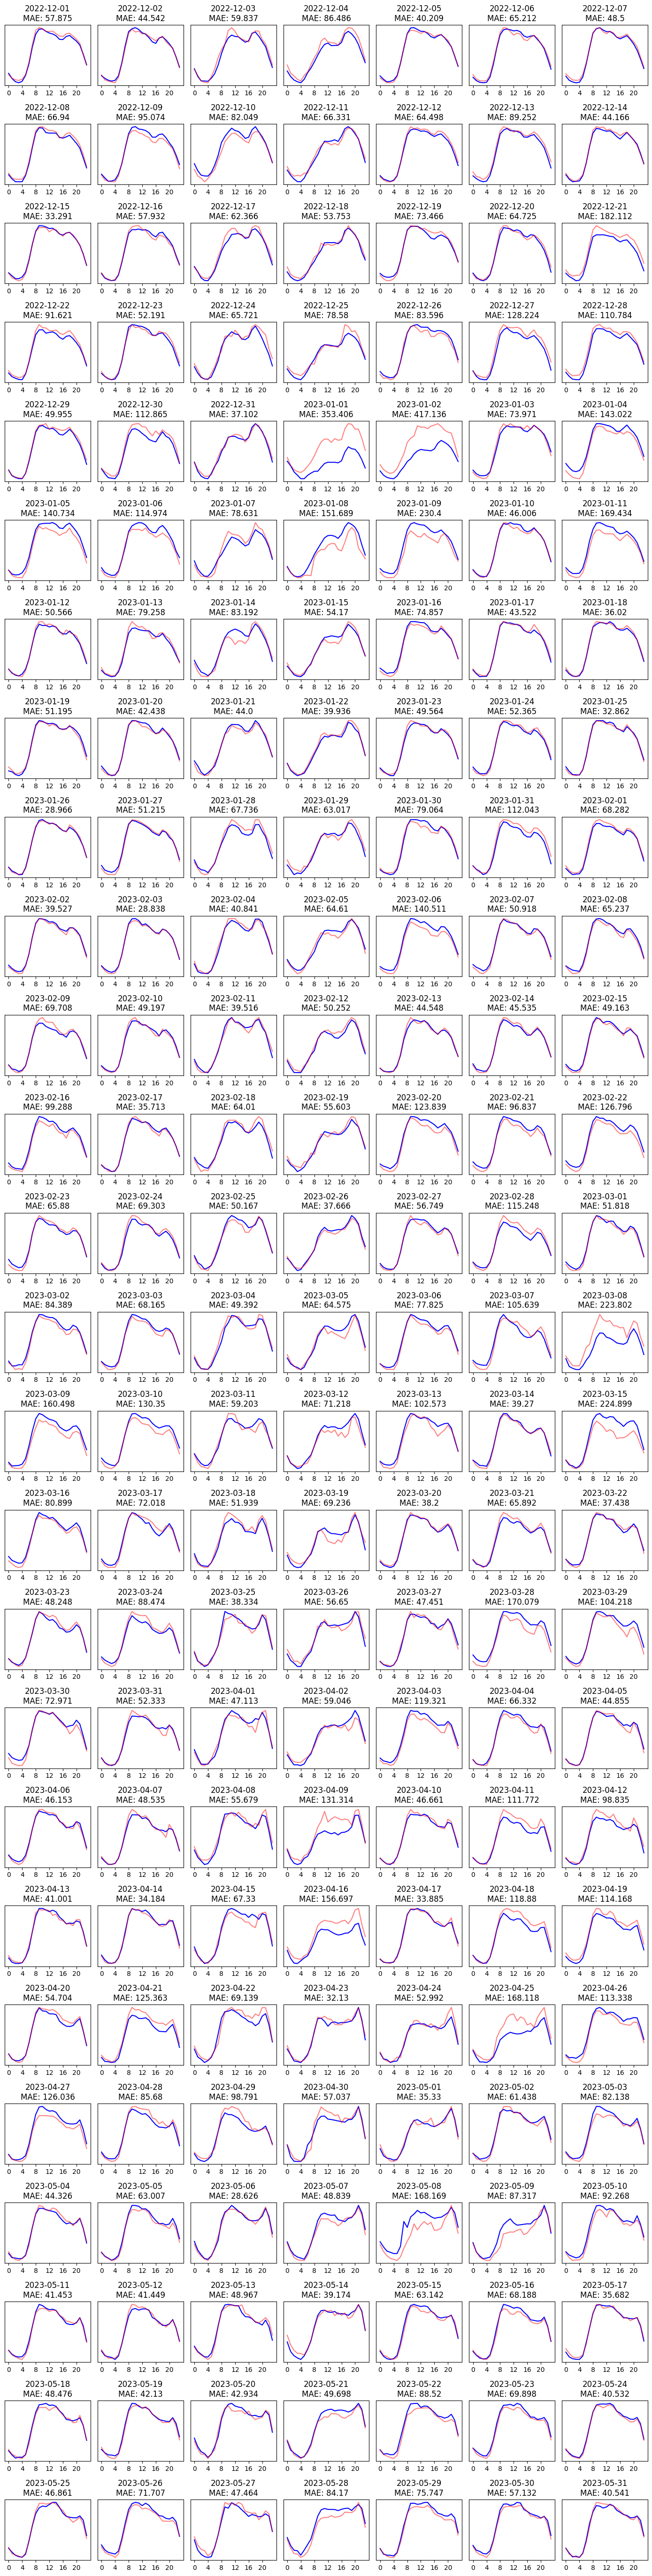

In [14]:
plot_predicts(df_true=global_y_test,
              df_pred=global_y_test_pred,
              days_shift=1)

Итоговый MAE на тестовых данных составил 77.125

In [15]:
# global_y_test_pred.to_csv('data_for_train/3.6/df_pred_LGBM.csv')